#### Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from cairosvg import svg2png
from PIL import Image
from io import BytesIO
from tqdm import tqdm
# from sklearn.metrics import roc_auc_score

pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

KAGGLE = 0

#### Global Variables

In [65]:
TRAIN_CSV_PATH = 'train.feather'
QUESTIONS_CSV_PATH = 'questions.csv'
LECTURES_CSV_PATH = 'lectures.csv'
SAMPLE_CSV_PATH = 'example_sample_submission.csv'
SAMPLE_TEST_CSV_PATH = 'example_test.csv'

if KAGGLE:
    TRAIN_CSV_PATH = '/kaggle/input/riiid-test-answer-prediction/train.csv'
    QUESTIONS_CSV_PATH = '/kaggle/input/riiid-test-answer-prediction/questions.csv'
    LECTURES_CSV_PATH = '/kaggle/input/riiid-test-answer-prediction/lectures.csv'
    SAMPLE_CSV_PATH = '/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv'
    SAMPLE_TEST_CSV_PATH = '/kaggle/input/riiid-test-answer-prediction/example_test.csv'

COLUMN_TYPES = {
    'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'boolean'
}

In [66]:
# train_df = pd.read_csv(TRAIN_CSV_PATH, nrows=10**5, dtype=COLUMN_TYPES)
train_df = pd.read_feather(TRAIN_CSV_PATH)
train_df = train_df.iloc[:1 * (10 ** 5)]
questions_df = pd.read_csv(QUESTIONS_CSV_PATH)
lectures_df = pd.read_csv(LECTURES_CSV_PATH)
sample_test_df = pd.read_csv(SAMPLE_TEST_CSV_PATH)

In [ ]:
sample_test_df

### Check for question specific features

In [4]:
questions_df[questions_df.tags.isna()] = questions_df[questions_df.tags.isna()].fillna("")
questions_df[questions_df.tags.isna()]

,question_id,bundle_id,correct_answer,part,tags


In [5]:
tag_counts = questions_df[['tags', 'question_id']].groupby('tags')['tags'].count()
tag_counts_list = list(tag_counts.sort_values().index.values)
questions_df['tag_count_wise_id'] = questions_df.apply(lambda row: tag_counts_list.index(row.tags), axis=1)

In [6]:
# Find the wrong and right question tags based on correctly answered
tags_list = [value.split() for value in questions_df.tags.values]

questions_df['tags_list'] = tags_list
questions_df['number_of_tags'] = questions_df.apply(lambda row: len(row.tags), axis=1)
questions_df['tags'] = questions_df['tags'].astype(str)

questions_df.head()

,question_id,bundle_id,correct_answer,part,tags,tag_count_wise_id,tags_list,number_of_tags
0,0,0,0,1,51 131 162 38,1055,"[51, 131, 162, 38]",13
1,1,1,1,1,131 36 81,963,"[131, 36, 81]",9
2,2,2,0,1,131 101 162 92,574,"[131, 101, 162, 92]",14
3,3,3,0,1,131 149 162 29,651,"[131, 149, 162, 29]",14
4,4,4,3,1,131 5 162 38,910,"[131, 5, 162, 38]",12


In [7]:
# The part content type of the question wheather if it is a listening section or a reading secition
questions_df['part_test_listening'] = True
reading_sections_parts = [5, 6, 7]
questions_df.loc[questions_df.part.isin(reading_sections_parts), 'part_test_listening'] = False
questions_df.part_test_listening.unique()

array([ True, False])

### The lecture specific data creation

In [8]:
# The lecture based dict for type of and part
lecture_dict = lectures_df.set_index("lecture_id").to_dict(orient="index")
lecture_comprehensive_type_of_dict = lectures_df.set_index('type_of').groupby(level=0).apply(lambda row: row.to_dict('list')).to_dict()
lecture_comprehensive_part_dict = lectures_df.set_index('part').groupby(level=0).apply(lambda row: row.to_dict('list')).to_dict()

In [9]:
for key in lecture_comprehensive_part_dict:
    lecture_comprehensive_part_dict[key]['tag'] = list(set(lecture_comprehensive_part_dict[key]['tag']))
    lecture_comprehensive_part_dict[key]['type_of'] = list(set(lecture_comprehensive_part_dict[key]['type_of']))

for key in lecture_comprehensive_type_of_dict:
    lecture_comprehensive_type_of_dict[key]['tag'] = list(set(lecture_comprehensive_type_of_dict[key]['tag']))
    lecture_comprehensive_type_of_dict[key]['part'] = list(set(lecture_comprehensive_type_of_dict[key]['part']))

### common function

In [10]:
def convert_timestamp_in_parts(millis):
    seconds = (millis / 1000)
    minutes = (seconds / 60)
    hours = (minutes / 60)
    days = (hours / 24)
    return days, hours, minutes, seconds

def get_timestamp_in_parts(row):
    millis = row.timestamp
    seconds = (millis / 1000)
    minutes = (seconds / 60)
    hours = (minutes / 60)
    days = (hours / 24)
    return days, hours

def get_prior_elasped_time_in_parts(row):
    prior_millis = row.prior_question_elapsed_time
    prior_seconds = (prior_millis / 1000)
    prior_minutes = (prior_seconds / 60)
    return prior_minutes

### Set User specific features

##### 1. Get timestamp as hours and minutes

In [11]:
train_df[['event_in_days', 'event_in_hours']] = [*train_df.apply(lambda row: get_timestamp_in_parts(row), axis=1)]
train_df['prior_minutes'] = train_df.apply(lambda row: get_prior_elasped_time_in_parts(row), axis=1)

##### 2. Find the intro rows.

In [12]:
# TODO: The intro section can also be calculated based on the bundle id
starter_ids = train_df[(train_df.timestamp == 0)].task_container_id.unique()
train_df['intro_section'] = train_df.apply(lambda row: (row.task_container_id in starter_ids or row.task_container_id == 0), axis=1)
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,event_in_days,event_in_hours,prior_minutes,intro_section
0,0,0,115,5692,0,1,3,1,nan,<NA>,0.00000,0.00000,nan,True
1,1,56943,115,5716,0,2,2,1,37000.00000,False,0.00066,0.01582,0.61667,False
2,2,118363,115,128,0,0,0,1,55000.00000,False,0.00137,0.03288,0.91667,True
3,3,131167,115,7860,0,3,0,1,19000.00000,False,0.00152,0.03644,0.31667,False
4,4,137965,115,7922,0,4,1,1,11000.00000,False,0.00160,0.03832,0.18333,False


##### 3. The actions after the lectures should be tagged with something.

In [13]:
question_dict = questions_df.set_index("question_id").to_dict(orient="index")

In [14]:
# https://en.wikipedia.org/wiki/Forgetting_curve
# https://psychology.stackexchange.com/questions/5199/which-equation-is-ebbinghauss-forgetting-curve-and-what-do-the-constants-repres
def apply_filter_based_on_previous_row(func):
    prev_row = {
        "has_seen_lecture": False,
        "previous_lecture_hours": 0,
        "previous_lecture": {},
        "user_id": ""
    }
    def wrapper(curr_row, **kwargs):
        content_id = curr_row['content_id']
        tag_of_prev_lecture = 0
        part_of_prev_lecture = 0
        has_seen_same_tag_as_lecture = False
        has_seen_same_part_as_lecture = False
        has_part_common_with_type_of = False
        has_tag_common_with_type_of = False
        has_tag_common_with_part_dict = False
        has_type_of_common_with_part_dict = False
        if prev_row['user_id'] == curr_row['user_id']:
            if curr_row['content_type_id'] != 0:
                prev_row['has_seen_lecture'] = True
                prev_row['previous_lecture_hours'] = curr_row['event_in_hours']
                prev_row['previous_lecture'] = lecture_dict[content_id]
            else:
                has_seen_same_tag_as_lecture = (str(prev_row['previous_lecture'].get("tag", "")) in str(question_dict[content_id]['tags']).split())
                has_seen_same_part_as_lecture = (prev_row['previous_lecture'].get("part") == question_dict[content_id]['part'])
                prev_type_of = prev_row['previous_lecture'].get("type_of")
                prev_part = prev_row['previous_lecture'].get("part")
                has_part_common_with_type_of = question_dict[content_id]['part'] in  lecture_comprehensive_type_of_dict.get(prev_type_of, {}).get('part', [])
                has_tag_common_with_type_of = bool(set(map(int, str(question_dict[content_id]['tags']).split())).intersection(lecture_comprehensive_type_of_dict.get(prev_type_of, {}).get('tag', [])))
                has_tag_common_with_part_dict = bool(set(map(int, str(question_dict[content_id]['tags']).split())).intersection(lecture_comprehensive_part_dict.get(prev_part, {}).get('tag', [])))
                has_type_of_common_with_part_dict = prev_type_of in lecture_comprehensive_part_dict[question_dict[content_id]['part']]['type_of']
                tag_of_prev_lecture = prev_row['previous_lecture'].get('tag', 0)
                part_of_prev_lecture = prev_row['previous_lecture'].get('part', 0)
        else:
            prev_row['user_id'] = curr_row['user_id']
            if curr_row['content_type_id'] != 0:
                prev_row['has_seen_lecture'] = True
                prev_row['previous_lecture_hours'] = curr_row['event_in_hours']
                prev_row['previous_lecture'] = lecture_dict[content_id]
            else:
                prev_row['has_seen_lecture'] = False
                prev_row['previous_lecture_hours'] = 0
                prev_row['previous_lecture'] = {}

        timestamp_difference = curr_row['event_in_hours'] - prev_row['previous_lecture_hours']
        retention = func(timestamp_difference)
        return retention, tag_of_prev_lecture, part_of_prev_lecture, prev_row['has_seen_lecture'], has_seen_same_tag_as_lecture, has_seen_same_part_as_lecture, has_part_common_with_type_of, has_tag_common_with_type_of, has_tag_common_with_part_dict, has_type_of_common_with_part_dict

    return wrapper

@apply_filter_based_on_previous_row
def running_retention(timestamp_difference):
    retention = 1.48 / ((1.25 * timestamp_difference) + 1.48)
    return retention

train_df["retention"], train_df["previous_lecture_tag"], train_df["previous_lecture_part"], train_df["has_seen_lecture_before"], train_df["has_seen_same_tag_as_lecture"], train_df["has_seen_same_part_as_lecture"], train_df["has_part_common_with_type_of"], train_df["has_tag_common_with_type_of"], train_df["has_tag_common_with_part_dict"], train_df["has_type_of_common_with_part_dict"] = zip(*train_df.apply(running_retention, axis=1))

In [15]:
train_df = train_df[train_df['content_type_id'] == 0]

##### 4. Now lets find out the lag time

In [16]:
# lag time
train_df['event_time'] = train_df[['user_id', 'timestamp']].groupby('user_id')['timestamp'].diff()
train_df['shift_event_time'] = train_df[['event_time', 'user_id']].groupby('user_id').event_time.shift(-1)
train_df['shift_elapsed_time'] = train_df[['prior_question_elapsed_time', 'user_id']].groupby('user_id').prior_question_elapsed_time.shift(-1)
train_df['event_lag_time'] = train_df['shift_event_time'] - train_df['shift_elapsed_time']

In [17]:
train_df_elapsed_time_groupby = train_df[['content_id', 'shift_elapsed_time']].groupby(['content_id']).shift_elapsed_time
individual_question_min_time_dict = train_df_elapsed_time_groupby.min().to_dict()
individual_question_mean_time_dict = train_df_elapsed_time_groupby.mean().to_dict()

del train_df_elapsed_time_groupby

In [18]:
# def get_lag_time(content_id, shift_event_time):
#     question_min_time = individual_question_min_time_dict[content_id]
#     return shift_event_time - question_min_time

# train_df['lag_time'] = train_df[train_df['content_type_id'] == 0].apply(lambda row: get_lag_time(row.content_id, row.shift_event_time), axis=1)

def get_prior_elapsed_time_difference(content_id, shift_elapsed_time):
    question_min_time = individual_question_min_time_dict[content_id]
    return shift_elapsed_time - question_min_time

train_df['lag_time'] = train_df.apply(lambda row: get_prior_elapsed_time_difference(row.content_id, row.shift_elapsed_time), axis=1)

In [19]:
def has_elapsed_time_greater_than_average_time(content_id, shift_elapsed_time):
    question_min_time = individual_question_mean_time_dict[content_id]
    return shift_elapsed_time > question_min_time

train_df['question_answered_late'] = train_df.apply(lambda row: has_elapsed_time_greater_than_average_time(row.content_id, row.shift_elapsed_time), axis=1)

In [20]:
average_question_timestamp_difference_dict = train_df[(train_df['shift_event_time'] < 3600000)][['content_id', 'shift_event_time']].groupby('content_id').shift_event_time.mean().to_dict()

In [21]:
def has_event_time_greater_than_average(content_id, event_time):
    average_question_time = average_question_timestamp_difference_dict.get(content_id, 0)
    return event_time > average_question_time

train_df['event_time_greater_than_average'] = train_df.apply(lambda row: has_event_time_greater_than_average(row.content_id, row.shift_event_time), axis=1)

##### 5. lets find the average time took for each question

In [22]:
# The average time per question can be considered based on the every candidate or based on the current candidate previous question answering time.

In [23]:
user_average_time_to_elapsed_dict = train_df.groupby("user_id").prior_question_elapsed_time.mean().to_dict()

In [24]:
train_df['question_took_more_than_average_user_time'] = train_df.apply(lambda row: row.prior_question_elapsed_time > user_average_time_to_elapsed_dict[row.user_id], axis=1)

In [25]:
# check average question answering time
average_question_prior_question_elapsed_time_dict = train_df.groupby(["content_id"]).prior_question_elapsed_time.mean().to_dict()

In [26]:
train_df.sort_values(['user_id', 'timestamp'], inplace=True)
bundle_time_relation_dict = {}

prev_row = {
    "user_id": "",
    "bundle_id": "",
    "previous_bundle_elapsed_time": ""
}


def get_question_time_taken(curr_row):
    current_bundle_id = question_dict[curr_row.content_id]['bundle_id']
    if prev_row['user_id'] == curr_row['user_id']:
        if prev_row['bundle_id'] == current_bundle_id:
            time_taken_for_question = prev_row['previous_bundle_elapsed_time']
        else:
            time_taken_for_question = curr_row['prior_question_elapsed_time']
            prev_row['previous_bundle_elapsed_time'] = curr_row['prior_question_elapsed_time']
            prev_row['bundle_id'] = current_bundle_id
    else:
        prev_row['bundle_id'] = current_bundle_id
        prev_row['previous_bundle_elapsed_time'] = curr_row['prior_question_elapsed_time']
        time_taken_for_question = 0
    prev_row['user_id'] = curr_row.user_id
    return time_taken_for_question


for index, row in train_df.iloc[::-1].iterrows():
    if row.content_id in bundle_time_relation_dict and bundle_time_relation_dict:
        bundle_time_relation_dict[row.content_id]['question_time_list'].append(get_question_time_taken(row))
    else:
        bundle_time_relation_dict[row.content_id] = {
            "question_time_list": [get_question_time_taken(row)]
        }

In [27]:
for content_id in bundle_time_relation_dict.keys():
    bundle_time_relation_dict[content_id]['minimum_time'] = min(bundle_time_relation_dict[content_id]['question_time_list'])
    bundle_time_relation_dict[content_id]['average_time'] = np.mean(bundle_time_relation_dict[content_id]['question_time_list'])

In [28]:
train_df['has_more_than_average_bundle_time'] = train_df.apply(lambda row: row.shift_elapsed_time < bundle_time_relation_dict[row.content_id]['average_time'], axis=1)

def get_bundle_lag_time(row):
    if row.shift_elapsed_time > bundle_time_relation_dict[row.content_id]['minimum_time']:
        return row.shift_elapsed_time - bundle_time_relation_dict[row.content_id]['minimum_time']
    return 0

train_df['bundle_lag_time'] = train_df.apply(lambda row: get_bundle_lag_time(row), axis=1)

##### 6. Find the toughest questions

In [29]:
# get all the complete tags of the question
tags = [value.split() for value in questions_df[questions_df.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)
print(f'There are {len(tags)} different tags')

There are 188 different tags


In [30]:
# Find the wrong and right question based on correctly answered
correct = train_df.groupby(["content_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "content_id", columns='answered_correctly', values='size')
correct.columns = ['wrong', 'right']
correct = correct.fillna(0)
correct[['wrong', 'right']] = correct[['wrong', 'right']].astype(int)
questions_df = questions_df.merge(correct, left_on = "question_id", right_on = "content_id", how = "left")
questions_df['percentage_correct'] = questions_df.right / (questions_df.right + questions_df.wrong)
questions_df.head()

# questions_df.drop(["wrong_x", "right_x", "wrong_y", "right_y"], axis=1, inplace=True)

,question_id,bundle_id,correct_answer,part,tags,tag_count_wise_id,tags_list,number_of_tags,part_test_listening,wrong,right,percentage_correct
0,0,0,0,1,51 131 162 38,1055,"[51, 131, 162, 38]",13,True,0.00000,6.00000,1.00000
1,1,1,1,1,131 36 81,963,"[131, 36, 81]",9,True,0.00000,3.00000,1.00000
2,2,2,0,1,131 101 162 92,574,"[131, 101, 162, 92]",14,True,16.00000,29.00000,0.64444
3,3,3,0,1,131 149 162 29,651,"[131, 149, 162, 29]",14,True,5.00000,20.00000,0.80000
4,4,4,3,1,131 5 162 38,910,"[131, 5, 162, 38]",12,True,11.00000,18.00000,0.62069


In [31]:
# TODO: This seems to be wrong please check again
train_df['question_bundle_id'] = train_df.apply(lambda row: question_dict[row.content_id].get('bundle_id'), axis=1)
correct = train_df.groupby(["question_bundle_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "question_bundle_id", columns='answered_correctly', values='size')
correct.columns = ['bundle_wrong', 'bundle_right']
correct = correct.fillna(0)
correct[['bundle_wrong', 'bundle_right']] = correct[['bundle_wrong', 'bundle_right']].astype(int)

questions_df = questions_df.merge(correct, left_on = "bundle_id", right_on = "question_bundle_id", how = "left")
questions_df['task_percentage_correct'] = questions_df.bundle_right / (questions_df.bundle_right + questions_df.bundle_wrong)
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags,tag_count_wise_id,tags_list,number_of_tags,part_test_listening,wrong,right,percentage_correct,bundle_wrong,bundle_right,task_percentage_correct
0,0,0,0,1,51 131 162 38,1055,"[51, 131, 162, 38]",13,True,0.00000,6.00000,1.00000,0.00000,6.00000,1.00000
1,1,1,1,1,131 36 81,963,"[131, 36, 81]",9,True,0.00000,3.00000,1.00000,0.00000,3.00000,1.00000
2,2,2,0,1,131 101 162 92,574,"[131, 101, 162, 92]",14,True,16.00000,29.00000,0.64444,16.00000,29.00000,0.64444
3,3,3,0,1,131 149 162 29,651,"[131, 149, 162, 29]",14,True,5.00000,20.00000,0.80000,5.00000,20.00000,0.80000
4,4,4,3,1,131 5 162 38,910,"[131, 5, 162, 38]",12,True,11.00000,18.00000,0.62069,11.00000,18.00000,0.62069


In [32]:
tags_df = pd.DataFrame()
for x in range(len(tags)):
    df = questions_df[questions_df.tags.apply(lambda l: tags[x] in l)]
    df1 = df.agg({'wrong': ['sum'], 'right': ['sum']})
    df1['total_questions'] = df1.wrong + df1.right
    df1['question_ids_with_tag'] = len(df)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['wrong', 'right', 'total_questions']] = tags_df[['wrong', 'right', 'total_questions']].astype(int)
tags_df['percent_correct'] = tags_df.right / tags_df.total_questions
tags_df = tags_df.sort_values(by = "percent_correct")

tags_df.head()

,wrong,right,total_questions,question_ids_with_tag,percent_correct
tag,,,,,
86,4,4,8,4,0.50000
186,3,3,6,3,0.50000
24,224,230,454,29,0.50661
151,239,248,487,16,0.50924
132,188,214,402,13,0.53234


In [33]:
# Question dict
questions_dict = questions_df[['question_id', 'percentage_correct', 'tags']].set_index('question_id').to_dict(orient='index')

In [34]:
# TODO: please check the values that is used in each question they might be wrong
def is_question_above_average_answering(row):
    percentage_correct = question_dict[row.content_id].get('percentage_correct')
    if percentage_correct:
        return percentage_correct > 50
    return False

def is_all_tags_above_average_answering(row):
    tags_answer_percentages = []
    tags = questions_dict[row.content_id].get('tags_list')
    if not tags:
        return False
    tags = tags
    for tag in tags:
        tags_answer_percentages.append(tags_df.loc[tag].percent_correct)
    overall_tag_percentage = sum(tags_answer_percentages) / len(tags)
    return overall_tag_percentage > 0.5

train_df['question_has_above_average_correctness'] = train_df.apply(lambda row: is_question_above_average_answering(row), axis=1)
train_df['tag_has_above_average_correctness'] = train_df.apply(lambda row: is_all_tags_above_average_answering(row), axis=1)

##### 6. toughtest questions relates to the lag time and the elapsed time

In [35]:
check_answered_correctly = (train_df.answered_correctly == 1)

In [36]:
lag_time_answered_correctly_mean_dict = train_df[check_answered_correctly][['content_id', 'lag_time']].groupby(['content_id']).lag_time.mean().to_dict()
train_df['has_above_average_lag_time_for_the_question'] = train_df.apply(lambda row: row.lag_time > lag_time_answered_correctly_mean_dict.get(row.content_id, 0), axis=1)

In [37]:
shift_elapsed_time_answered_correctly_mean_dict = train_df[check_answered_correctly][['content_id', 'shift_elapsed_time']].groupby(['content_id']).shift_elapsed_time.mean().to_dict()
train_df['has_above_average_shift_elpased_time_for_the_question'] = train_df.apply(lambda row: row.shift_elapsed_time > shift_elapsed_time_answered_correctly_mean_dict.get(row.content_id, 0), axis=1)

In [38]:
# 1. Lag time based on the min/average question time - Done
# 2. Check if the average question time is greater than or not - Done
# 3. The timestamp is greater or not - Done
# 4. check if the top users and top interactions has any relation - Must be run on full dataset
# 5. Find the toughest question - Done
# 6. Find if the toughest question relates to the lag time - Done
# 7. Find if the toughest question relates to the elapsed time - Done


##### 7. The prior time mean for each user should be averaged to check if the user too more than usual

In [39]:
# TODO: Do the following by setting the time rather than setting the flag
# BUG: The comparison seems to be wrong 
elapsed_time_mean_dict = train_df[check_answered_correctly][['shift_elapsed_time', 'user_id']].groupby('user_id').shift_elapsed_time.mean().to_dict()
train_df['has_above_user_average_time_to_answer'] = train_df[['user_id', 'shift_elapsed_time']].apply(lambda row: elapsed_time_mean_dict.get(row.user_id, 0) <= row.shift_elapsed_time, axis=1)

In [40]:
event_time_mean_dict = train_df[check_answered_correctly][['event_time', 'user_id']].groupby('user_id').event_time.mean().to_dict()
train_df['has_above_user_average_time_for_event'] = train_df[['user_id', 'event_time']].apply(lambda row: event_time_mean_dict.get(row.user_id, 0) <= row.event_time, axis=1)

In [41]:
shift_event_time_mean_dict = train_df[check_answered_correctly][['shift_event_time', 'user_id']].groupby('user_id').shift_event_time.mean().to_dict()
train_df['has_above_user_average_time_for_event'] = train_df[['user_id', 'shift_event_time']].apply(lambda row: shift_event_time_mean_dict.get(row.user_id, 0) <= row.shift_event_time, axis=1)

##### 8. cum correctness of the answers made by the user

In [42]:
cum = train_df.groupby('user_id')['answered_correctly'].agg(['cumsum', 'cumcount'])
train_df['user_cum_correctness'] = cum['cumsum'] / cum['cumcount']
train_df['user_correct_cumsum'] = cum['cumsum']
train_df['user_correct_cumcount'] = cum['cumcount']

train_df['user_correct_cumsum'].fillna(0, inplace=True)
train_df.user_cum_correctness = train_df.user_cum_correctness.astype('float16')
train_df.user_correct_cumcount = train_df.user_correct_cumcount.astype('int16')
train_df.user_correct_cumsum = train_df.user_correct_cumsum.astype('int16')

user_agg = train_df.groupby('user_id')['answered_correctly'].agg(['sum', 'count'])
user_agg = user_agg.astype('int16')
train_df['user_correctness'] = user_agg['sum'] / user_agg['count']
train_df['user_correct_sum'] = user_agg['sum']
train_df['user_correct_count'] = user_agg['count']

train_df['user_correct_sum'].fillna(0, inplace=True)
train_df['user_correct_count'].fillna(0, inplace=True)
train_df.user_correctness = train_df.user_correctness.astype('float16')
train_df.user_correct_count = train_df.user_correct_count.astype('int16')
train_df.user_correct_sum = train_df.user_correct_sum.astype('int16')

##### 9. cum of prior question had seen explanation 

In [43]:
train_df['has_seen_question_explanation'] = train_df.groupby('user_id').prior_question_had_explanation.shift(-1)

In [44]:
cum = train_df.groupby('user_id')['has_seen_question_explanation'].agg(['cumsum', 'cumcount'])
train_df['explanation_mean'] = cum['cumsum'] / cum['cumcount']
train_df['explanation_cumsum'] = cum['cumsum'] 

train_df['explanation_mean'].fillna(0, inplace=True)
train_df['explanation_cumsum'].fillna(0, inplace=True)
train_df.explanation_mean = train_df.explanation_mean.astype('float16')
train_df.explanation_cumsum = train_df.explanation_cumsum.astype('int16')

##### 10. The attempt feature

In [45]:
train_df["attempt_no"] = 1
train_df.attempt_no = train_df.attempt_no.astype('int8')
train_df["attempt_no"] = train_df[["user_id", "content_id", "attempt_no"]].groupby(["user_id", "content_id"])["attempt_no"].cumsum()

In [46]:
attempt_no_agg = train_df.groupby(["user_id","content_id"])["attempt_no"].agg(['sum'])
attempt_no_agg = attempt_no_agg.astype('int8')

##### 11. The aggregate of the answered correctly with the user_id, content_id, task_container_id

In [47]:
content_agg = train_df.groupby('content_id')['answered_correctly'].agg(['sum', 'count','var'])
content_agg = content_agg.astype('float32')
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
train_df['content_sum'] = train_df['content_id'].map(content_agg['sum']).astype('int32')
train_df['content_correctness'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])
train_df.content_correctness = train_df.content_correctness.astype('float16')

##### 12. get harmonic mean of the content

In [48]:
train_df['hmean_user_content_accuracy'] = 2 * (
    (train_df['user_correctness'] * train_df['content_correctness']) /
    (train_df['user_correctness'] + train_df['content_correctness'])
)

##### 13. Check if the user clicked the correct answer by chance

In [49]:
train_df['luckily_answered_correctly'] = train_df.apply(lambda row: row.attempt_no == 0 and row.has_seen_question_explanation and row.answered_correctly, axis=1)

##### 13. The aggregate of the answered correctly with the bundle_id, part, part content type

In [50]:
train_df = train_df.join(questions_df.set_index("question_id"), 'content_id', how='left')

In [51]:
bundle_agg = train_df.groupby('bundle_id')['answered_correctly'].agg(['sum', 'count','var'])
bundle_agg = bundle_agg.astype('float32')
train_df['bundle_sum'] = train_df['bundle_id'].map(bundle_agg['sum']).astype('int32')
train_df['bundle_std'] = train_df['bundle_id'].map(bundle_agg['var']).astype('float16')
train_df['bundle_correctness'] = train_df['bundle_id'].map(bundle_agg['sum'] / bundle_agg['count'])
train_df.bundle_correctness=train_df.bundle_correctness.astype('float16')

In [52]:
part_agg = train_df.groupby('part')['answered_correctly'].agg(['sum', 'count','var'])
part_agg = part_agg.astype('float32')
train_df['part_sum'] = train_df['part'].map(part_agg['sum']).astype('int32')
train_df['part_std'] = train_df['part'].map(part_agg['var']).astype('float16')
train_df['part_correctness'] = train_df['part'].map(part_agg['sum'] / part_agg['count'])
train_df.part_correctness=train_df.part_correctness.astype('float16')

In [53]:
part_test_listening_agg = train_df.groupby('part_test_listening')['answered_correctly'].agg(['sum', 'count','var'])
part_test_listening_agg = part_test_listening_agg.astype('float32')
train_df['part_test_listening_sum'] = train_df['part_test_listening'].map(part_test_listening_agg['sum']).astype('int32')
train_df['part_test_listening_std'] = train_df['part_test_listening'].map(part_test_listening_agg['var']).astype('float16')
train_df['part_test_listening_correctness'] = train_df['part_test_listening'].map(part_test_listening_agg['sum'] / part_test_listening_agg['count'])
train_df.part_test_listening_correctness=train_df.part_test_listening_correctness.astype('float16')

### Training 

In [54]:
X_val = train_df.groupby('user_id').tail(5)
X_train = train_df[~train_df.index.isin(X_val.index)]
y_train = X_train.answered_correctly
y_val = X_val.answered_correctly

In [55]:
features = ['user_id', 'content_id',
       'task_container_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'event_in_days',
       'event_in_hours', 'prior_minutes', 'intro_section', 'retention',
       'previous_lecture_tag', 'previous_lecture_part',
       'has_seen_lecture_before', 'has_seen_same_tag_as_lecture',
       'has_seen_same_part_as_lecture', 'has_part_common_with_type_of',
       'has_tag_common_with_type_of', 'has_tag_common_with_part_dict',
       'has_type_of_common_with_part_dict', 'event_time', 'shift_event_time',
       'shift_elapsed_time', 'event_lag_time', 'lag_time',
       'question_answered_late', 'event_time_greater_than_average',
       'question_took_more_than_average_user_time',
       'has_more_than_average_bundle_time', 'bundle_lag_time',
       'question_bundle_id', 'question_has_above_average_correctness',
       'tag_has_above_average_correctness',
       'has_above_average_lag_time_for_the_question',
       'has_above_average_shift_elpased_time_for_the_question',
       'has_above_user_average_time_to_answer',
       'has_above_user_average_time_for_event', 'user_cum_correctness',
       'user_correct_cumsum', 'user_correct_cumcount',
       'has_seen_question_explanation', 'explanation_mean',
       'explanation_cumsum', 'attempt_no', 'content_count', 'content_sum',
       'content_correctness', 'user_correctness', 'user_correct_sum',
       'user_correct_count', 'hmean_user_content_accuracy', 'bundle_id',
       'part', 'tag_count_wise_id',
       'number_of_tags', 'wrong', 'right', 'percentage_correct',
       'bundle_wrong', 'bundle_right', 'task_percentage_correct', 'bundle_sum',
       'bundle_std', 'bundle_correctness', 'part_test_listening', 'part_sum',
       'part_std', 'part_correctness', 'part_test_listening_sum',
       'part_test_listening_std', 'part_test_listening_correctness', 'luckily_answered_correctly']

categorical_feature = ['content_id',
       'prior_question_elapsed_time', 'prior_question_had_explanation', 'event_in_days',
       'even_in_hours', 'prior_minutes', 'intro_section', 'retention',
       'previous_lecture_tag', 'previous_lecture_part',
       'has_seen_lecture_before', 'has_seen_same_tag_as_lecture',
       'has_seen_same_part_as_lecture', 'has_part_common_with_type_of',
       'has_tag_common_with_type_of', 'has_tag_common_with_part_dict',
       'has_type_of_common_with_part_dict','question_answered_late', 'event_time_greater_than_average',
       'question_took_more_than_average_user_time',
       'has_more_than_average_bundle_time', 'question_has_above_average_correctness',
       'tag_has_above_average_correctness',
       'has_above_average_lag_time_for_the_question',
       'has_above_average_shift_elpased_time_for_the_question',
       'has_above_user_average_time_to_answer',
       'has_above_user_average_time_for_event', 'has_seen_question_explanation', 'part', 'part_test_listening', 'luckily_answered_correctly']

categorical_feature_idxs = []
for feature_name in categorical_feature:
    try:
        categorical_feature_idxs.append(features.index(feature_name))
    except:
        pass

In [56]:
X_train = X_train[features]
X_val = X_val[features]

In [57]:
X_train.has_seen_question_explanation = X_train.has_seen_question_explanation.fillna(False).astype(np.bool)
X_val.has_seen_question_explanation = X_val.has_seen_question_explanation.fillna(False).astype(np.bool)

X_train.prior_question_had_explanation = X_train.prior_question_had_explanation.fillna(False).astype(np.bool)
X_val.prior_question_had_explanation = X_val.prior_question_had_explanation.fillna(False).astype(np.bool)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96443 entries, 0 to 99994
Data columns (total 71 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   user_id                                                96443 non-null  int32  
 1   content_id                                             96443 non-null  int16  
 2   task_container_id                                      96443 non-null  int16  
 3   prior_question_elapsed_time                            96097 non-null  float32
 4   prior_question_had_explanation                         96443 non-null  bool   
 5   event_in_days                                          96443 non-null  float64
 6   event_in_hours                                         96443 non-null  float64
 7   prior_minutes                                          96097 non-null  float64
 8   intro_section                                 

In [58]:
lgbm_params = {
    'objective': 'binary',
    "metric": 'auc',
    'num_leaves': 350,
    'max_bin':700,
    'min_child_weight': 0.03454472573214212,
    'feature_fraction': 0.58,
    'bagging_fraction': 0.58,
    #'min_data_in_leaf': 106,
    'max_depth': -1,
    'learning_rate': 0.05,
    "boosting_type": "gbdt",
    "bagging_seed": 11,
    "verbosity": -1,
    'reg_alpha': 0.3899927210061127,
    'reg_lambda': 0.6485237330340494,
    'random_state': 47
}

In [59]:
train_data = lgb.Dataset(
    data = X_train,
    label = y_train,
    categorical_feature = None,
)

val_data = lgb.Dataset(
    data = X_val,
    label = y_val,
    categorical_feature = None,
)

In [60]:
del X_train, y_train, X_val, y_val
import gc
gc.collect()

60

In [61]:
def train():
    evals_result = {}
    model = lgb.train(
        params = lgbm_params,
        train_set = train_data,
        valid_sets = [val_data],
        num_boost_round = 5000,
        verbose_eval = 50,
        evals_result = evals_result,
        early_stopping_rounds = 50, 
        categorical_feature = categorical_feature_idxs,
        feature_name = features,
    )

    # save model
    model.save_model(f'model_v1_2500.lgb')
    
    return model, evals_result
    
model, evals_result = train()

Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.801152
[100]	valid_0's auc: 0.803802
Early stopping, best iteration is:
[88]	valid_0's auc: 0.80477


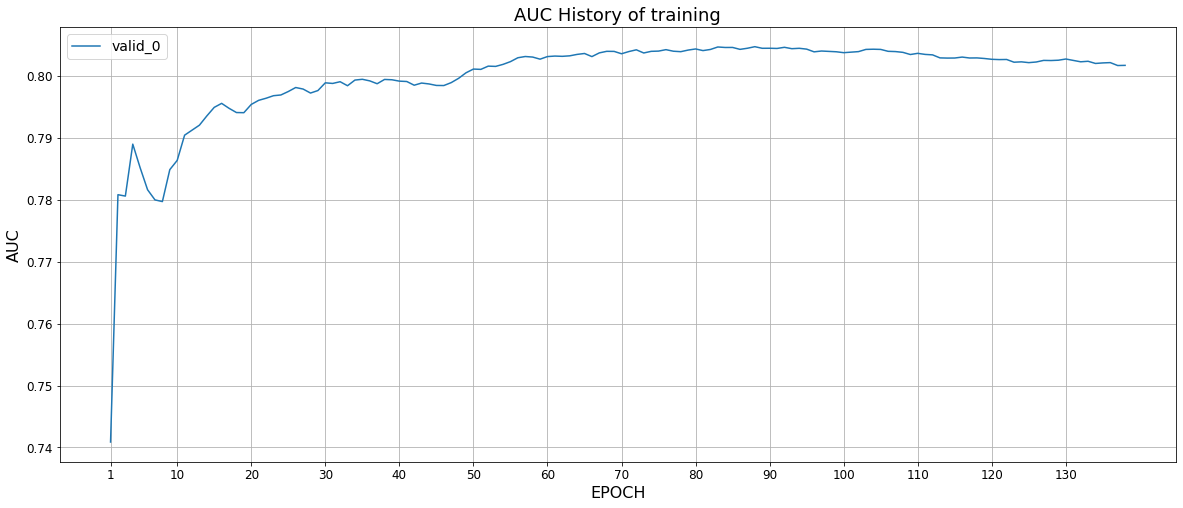

In [62]:
def plot_history(evals_result):
    for metric in ['auc']:
        plt.figure(figsize=(20,8))
        
        for key in evals_result.keys():
            history_len = len(evals_result.get(key)[metric])
            history = evals_result.get(key)[metric]
            x_axis = np.arange(1, history_len + 1)
            plt.plot(x_axis, history, label=key)
        
        x_ticks = list(filter(lambda e: (e % (history_len // 100 * 10) == 0) or e == 1, x_axis))
        plt.xticks(x_ticks, fontsize=12)
        plt.yticks(fontsize=12)

        plt.title(f'{metric.upper()} History of training', fontsize=18);
        plt.xlabel('EPOCH', fontsize=16)
        plt.ylabel(metric.upper(), fontsize=16)
        
        if metric in ['auc']:
            plt.legend(loc='upper left', fontsize=14)
        else:
            plt.legend(loc='upper right', fontsize=14)
        plt.grid()
        plt.show()

plot_history(evals_result)

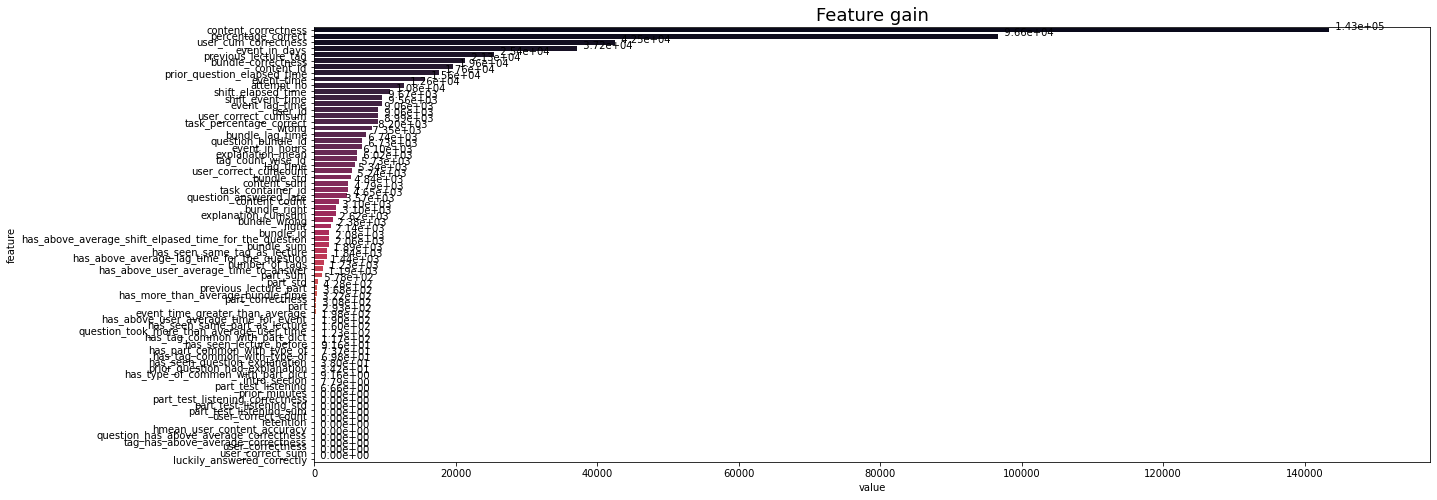

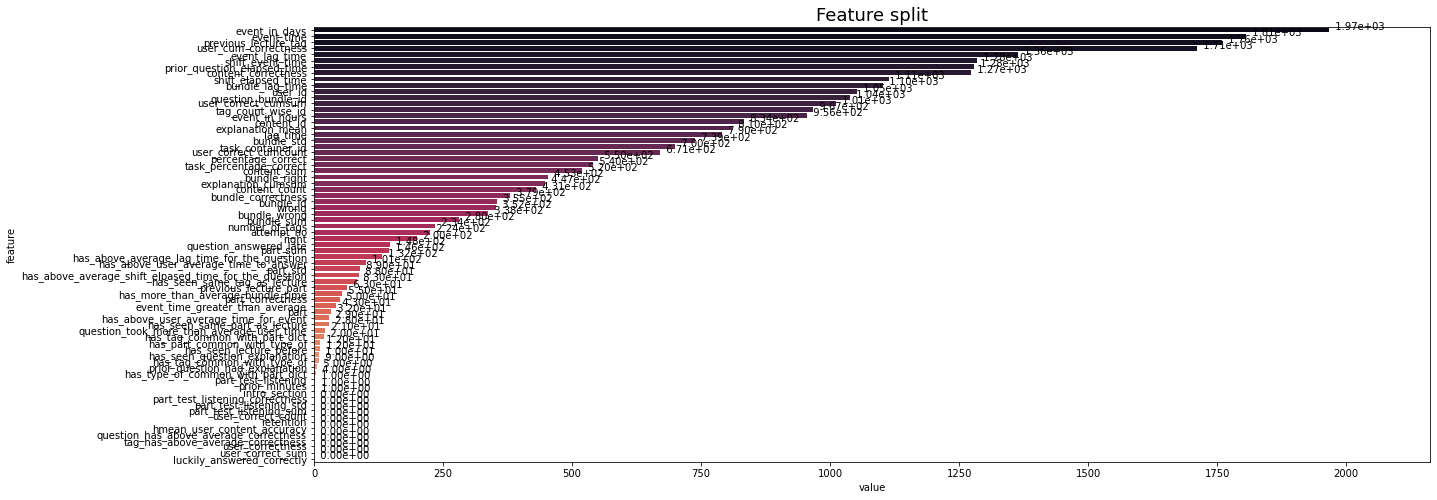

In [63]:
# plot the feature importance in terms of gain and split
def show_feature_importances(model, importance_type, max_num_features=10**10):
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = features
    feature_importances['value'] = pd.DataFrame(model.feature_importance(importance_type))
    feature_importances = feature_importances.sort_values(by='value', ascending=False) # sort feature importance
    feature_importances.to_csv(f'feature_importances_{importance_type}.csv') # write feature importance to csv
    feature_importances = feature_importances[:max_num_features] # only show max_num_features
    
    plt.figure(figsize=(20, 8))
    plt.xlim([0, feature_importances.value.max()*1.1])
    plt.title(f'Feature {importance_type}', fontsize=18);
    sns.barplot(data=feature_importances, x='value', y='feature', palette='rocket');
    for idx, v in enumerate(feature_importances.value):
        plt.text(v, idx, "  {:.2e}".format(v))

show_feature_importances(model, 'gain')
show_feature_importances(model, 'split')

In [64]:
# show tree and save as png
def save_tree_diagraph(model):
    tree_digraph = lgb.create_tree_digraph(model, show_info=['split_gain', 'internal_count'])

    tree_png = svg2png(tree_digraph._repr_svg_(), output_width=3840)
    tree_png = Image.open(BytesIO(tree_png))

    tree_png.save('create_tree_digraph.png')

    display(tree_png)
    
save_tree_diagraph(model)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [ ]:
# remove train and validation data to free memory before prediction phase
del train_data
gc.collect()

In [ ]:
# updates the user data
def update_user_data(state, features_questions_df, prev_test_df):
    for user_id, content_id, answered_correctly in prev_test_df[['user_id', 'content_id', 'answered_correctly']].values:
        # update user features
        state[user_id]['answered_correctly_user'] += answered_correctly
        state[user_id]['answered_user'] += 1
        state[user_id]['mean_user_accuracy'] = state[user_id]['answered_correctly_user'] / state[user_id]['answered_user']

In [ ]:
def get_user_data(state, test_df):
    # updated data
    attempt, mean_user_accuracy, answered_correctly_user, answered_user = [], [], [], []
    
    for idx, (user_id, content_id) in test_df[['user_id', 'content_id']].iterrows():
        # check if user exists
        if user_id in state:
            # check if user already answered the question, if so update it to a maximum of 4
            if content_id in state[user_id]['user_content_attempts']:
                state[user_id]['user_content_attempts'][content_id] = min(4, state[user_id]['user_content_attempts'][content_id] + 1)
            # if user did not answered the question already, set the number of attempts to 0
            else:
                state[user_id]['user_content_attempts'][content_id] = 0
        
        # else create user with default values
        else:
            dict_keys = ['mean_user_accuracy', 'answered_correctly_user', 'answered_user', 'user_content_attempts']
            dict_default_vals = [0.680, 0, 0, dict(zip([content_id],[0]))]
            state[user_id] = dict(zip(dict_keys, dict_default_vals))
            
        # add user data to lists
        attempt.append(state[user_id]['user_content_attempts'][content_id])
        mean_user_accuracy.append(state[user_id]['mean_user_accuracy'])
        answered_correctly_user.append(state[user_id]['answered_correctly_user'])
        answered_user.append(state[user_id]['answered_user'])
    
    return attempt, mean_user_accuracy, answered_correctly_user, answered_user

### prediction

In [ ]:
import riiideducation

env = riiideducation.make_env()
iter_test = env.iter_test()